In [1]:
import os
import numpy as np
import pandas as pd
from neuroHarmonize import harmonizationLearn, harmonizationApply

# Paths
data_dir = "/home/kexinguo/Combat545/data/train/train_vbm"
label_path = "/home/kexinguo/Combat545/data/train/official_site_class_labels.tsv"
memmap_path = "features_vbm_memmap.dat"
subject_id_path = "subject_ids_vbm.npy"

In [3]:
bad_files = []

for fname in sorted(os.listdir(data_dir)):
    if fname.endswith(".npy"):
        path = os.path.join(data_dir, fname)
        try:
            data = np.load(path, allow_pickle=False)
        except Exception as e:
            print(f"Cannot load {fname}: {e}")
            bad_files.append(fname)

print(f"\nTotal bad files: {len(bad_files)}")

Cannot load sub-671852511180_preproc-cat12vbm_desc-gm_T1w.npy: Cannot load file containing pickled data when allow_pickle=False
Cannot load sub-671881150872_preproc-cat12vbm_desc-gm_T1w.npy: Cannot load file containing pickled data when allow_pickle=False
Cannot load sub-672403936752_preproc-cat12vbm_desc-gm_T1w.npy: Cannot load file containing pickled data when allow_pickle=False
Cannot load sub-672500627179_preproc-cat12vbm_desc-gm_T1w.npy: Cannot load file containing pickled data when allow_pickle=False
Cannot load sub-672611254530_preproc-cat12vbm_desc-gm_T1w.npy: Cannot load file containing pickled data when allow_pickle=False
Cannot load sub-673092908902_preproc-cat12vbm_desc-gm_T1w.npy: Cannot load file containing pickled data when allow_pickle=False
Cannot load sub-673884038980_preproc-cat12vbm_desc-gm_T1w.npy: Cannot load file containing pickled data when allow_pickle=False
Cannot load sub-674684870917_preproc-cat12vbm_desc-gm_T1w.npy: Cannot load file containing pickled data 

In [5]:
bad_files = set(bad_files)
meta = pd.read_csv(label_path, sep="\t")
meta['participant_id'] = meta['participant_id'].astype(str)
print(meta)
# List all .npy files
npy_files = sorted([f for f in os.listdir(data_dir) if f.endswith(".npy") and f not in bad_files])
n_subjects = len(npy_files)
sample_shape = np.load(os.path.join(data_dir, npy_files[0])).shape
n_voxels = np.prod(sample_shape)

# Preallocate disk-backed memmap
features = np.memmap(memmap_path, dtype='float32', mode='w+', shape=(n_subjects, n_voxels))
subject_ids = []

for i, fname in enumerate(npy_files):
    subj_id = fname.split("_")[0].split("-")[1]
    subject_ids.append(subj_id)

    arr = np.load(os.path.join(data_dir, fname)).astype(np.float32)
    features[i] = arr.flatten()

features.flush()
np.save(subject_id_path, subject_ids)

print("Feature matrix shape:", features.shape)

     participant_id  siteXacq
0      100053248969         0
1      100263562592         1
2      100479214233         2
3      100544064116         4
4      101404752059         1
...             ...       ...
3222   998375364631        37
3223   998567081914        46
3224   999027816075         2
3225   999184404925         3
3226   999832619027         3

[3227 rows x 2 columns]
Feature matrix shape: (2095, 2122945)


def detect_file_type(path):
    with open(path, "rb") as f:
        magic = f.read(4)
    return magic

for fname in bad_files:
    path = os.path.join(data_dir, fname)
    try:
        sig = detect_file_type(path)
        print(f"{fname} → magic bytes: {sig}")
    except Exception as e:
        print(f"{fname} → unreadable: {e}")


In [6]:
print(subject_ids)  # e.g., ['100053248969', '100263562592', ...]

['100053248969', '100263562592', '100479214233', '100544064116', '101404752059', '101942030871', '102730278561', '103116472269', '103326586557', '104230378530', '104333986026', '104625609853', '104654659650', '104756934188', '104774505992', '104893688989', '105288153937', '105626036276', '105699817140', '105890017872', '106084308551', '106297012000', '106847803341', '107012705146', '107385462103', '107912335979', '108019181067', '108681547305', '108737376161', '108893451515', '109712998508', '109861838866', '110463604078', '110513034050', '110519368768', '110648343433', '111020130501', '111417977585', '111786255278', '112139632444', '112365363383', '112581979205', '113308512211', '113484693835', '113812293828', '114165623285', '114383938758', '115044780386', '115179082434', '115321957741', '116096622843', '116218240872', '116602902372', '116651167956', '117262576182', '117310191719', '117722182135', '117730404599', '118300283712', '119019619320', '119139956064', '119167600899', '119194

In [7]:
meta_ids = meta["participant_id"].astype(str).tolist()
valid_ids = [sid for sid in meta_ids if sid in subject_ids]
np.array_equal(subject_ids, valid_ids)

True

In [39]:
print(meta.columns.tolist())
print("Min value:", np.min(features[0]))
print("Max value:", np.max(features[0]))
print("Mean value:", np.mean(features[0]))
print("Std value:", np.std(features[0]))

['participant_id', 'siteXacq']
Min value: 0.0
Max value: 2.0666667888872325
Mean value: 0.09452458643156482
Std value: 0.23597923963481374


In [8]:
# Ensure correct dtype
meta['participant_id'] = meta['participant_id'].astype(str)

# Align rows in the same order as features
meta_sub = meta.set_index("participant_id").loc[subject_ids]
batch = meta_sub['siteXacq'].values

#print(meta_sub)
print(batch)
#print(meta_sub.index.tolist())  # should match subject_ids
#print(meta_sub["siteXacq"].values)  # your batch variable for ComBat

[ 0  1  2 ... 43 50  3]


In [9]:
# Create covars DataFrame with site as 'SITE'
covars = pd.DataFrame({
    "SITE": meta_sub["siteXacq"].values
}, index=meta_sub.index)

print(covars["SITE"].value_counts())

3     584
1     154
10    153
17    146
24     93
16     92
4      64
36     41
25     39
19     35
11     31
22     30
42     29
49     24
34     24
43     23
5      23
8      23
28     23
32     23
6      21
27     19
37     19
14     19
26     19
18     19
54     18
56     16
12     15
30     15
23     14
55     14
58     14
41     13
39     13
35     13
52     12
50     12
62     11
0      11
9      10
20      9
61      9
51      9
46      9
40      9
45      8
2       8
63      8
29      7
38      7
47      7
7       7
33      6
60      6
44      6
53      5
21      4
Name: SITE, dtype: int64


covars = pd.DataFrame({
    "SITE": meta_sub["siteXacq"].values
}, index=meta_sub.index)

print(covars["SITE"].value_counts())
features_filtered_combat = combat_by_block(features_subset, covars, block_size=30000)
print("Harmonized shape:", features_filtered_combat.shape)

In [10]:
def combat_by_block(features, covars, block_size):
    n_subjects, n_voxels = features.shape
    harmonized = np.zeros_like(features)

    for start in range(0, n_voxels, block_size):
        end = min(start + block_size, n_voxels)
        print(f"Processing block {start}:{end}")

        block = features[:, start:end]
        try:
            model, _ = harmonizationLearn(block, covars, ref_batch="3")
            harmonized[:, start:end] = harmonizationApply(block, covars, model)
        except Exception as e:
            print(f"Skipped block {start}:{end} due to error: {e}")
            harmonized[:, start:end] = block  # fallback: leave unharmonized

    return harmonized

print("NaNs:", np.isnan(features_filtered_combat).sum())

# Start with the original full feature matrix
features_combat = features.copy()

# Replace only the top site-sensitive features
features_combat[:, top_indices] = features_filtered_combat

print("Final combined feature shape:", features_combat.shape)

# Apply ComBat
covars = pd.DataFrame({
    "SITE": meta_sub["siteXacq"].values
}, index=meta_sub.index)
model, _ = harmonizationLearn(features, covars)  # ignore s_data
features_combat = harmonizationApply(features, covars, model)


print("Harmonized shape:", features_combat.shape)

In [11]:
# Calculate std across subjects for each voxel
stds = np.std(features, axis=0)

# Keep only features with non-trivial variation
threshold = 0.05
mask = stds > threshold
features_filtered = features[:, mask]

print("Original shape:", features.shape)
print("Filtered shape:", features_filtered.shape)

Original shape: (2095, 2122945)
Filtered shape: (2095, 417601)


In [12]:
features_filtered_combat = combat_by_block(features_filtered, covars, block_size=30000)
print("Harmonized shape:", features_filtered_combat.shape)

Processing block 0:30000
[neuroHarmonize] batch.ref not found. Setting to None.


/home/kexinguo/.local/lib/python3.9/site-packages/neuroCombat/neuroCombat.py:324: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


Processing block 30000:60000
[neuroHarmonize] batch.ref not found. Setting to None.
Processing block 60000:90000
[neuroHarmonize] batch.ref not found. Setting to None.
Processing block 90000:120000
[neuroHarmonize] batch.ref not found. Setting to None.
Processing block 120000:150000
[neuroHarmonize] batch.ref not found. Setting to None.
Processing block 150000:180000
[neuroHarmonize] batch.ref not found. Setting to None.
Processing block 180000:210000
[neuroHarmonize] batch.ref not found. Setting to None.
Processing block 210000:240000
[neuroHarmonize] batch.ref not found. Setting to None.
Processing block 240000:270000
[neuroHarmonize] batch.ref not found. Setting to None.
Processing block 270000:300000
[neuroHarmonize] batch.ref not found. Setting to None.
Processing block 300000:330000
[neuroHarmonize] batch.ref not found. Setting to None.
Processing block 330000:360000
[neuroHarmonize] batch.ref not found. Setting to None.
Processing block 360000:390000
[neuroHarmonize] batch.ref n

In [13]:
print("NaNs:", np.isnan(features_filtered_combat).sum())
#print("Infs:", np.isinf(features_combat).sum())

NaNs: 0


In [14]:
features_combat = np.zeros_like(features)
features_combat[:, mask] = features_filtered_combat
np.save("features_combat_vbm.npy", features_combat)
# to reload
## features_combat = np.memmap("features_vbm_memmap.dat", dtype='float32', shape=(3227, 2122945), mode='r')

print(features[20, 0:1000])
print(features_combat[0:5, 0:8])

print(np.std(features[:, :100], axis=0))  # std across subjects
#print(covars["SITE"].value_counts())
print(np.std(features_combat[:, :100], axis=0))

import matplotlib.pyplot as plt

# data_original: shape (n_subjects, n_features) BEFORE ComBat
# data_harmonized: shape (n_subjects, n_features) AFTER ComBat
# sites: 1D array of site labels for each subject

# Subject-level means before & after
subject_means_before = features.mean(axis=1)
subject_means_after = features_combat.mean(axis=1)

# Optional: convert site labels to np.array if needed
sites = np.array(meta_sub["siteXacq"])

# Determine y-axis range
#ymin = min(subject_means_before.min(), subject_means_after.min())
#ymax = max(subject_means_before.max(), subject_means_after.max())

# Make two boxplots: before and after
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].boxplot([
    subject_means_before[sites == 3],
    subject_means_before[sites == 8]
], labels=['Site 3', 'Site 8'])
axes[0].set_title("Subject Means Before ComBat")
#axes[0].set_ylim(ymin, ymax)

axes[1].boxplot([
    subject_means_after[sites == 3],
    subject_means_after[sites == 8]
], labels=['Site 3', 'Site 8'])
axes[1].set_title("Subject Means After ComBat")
#axes[1].set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

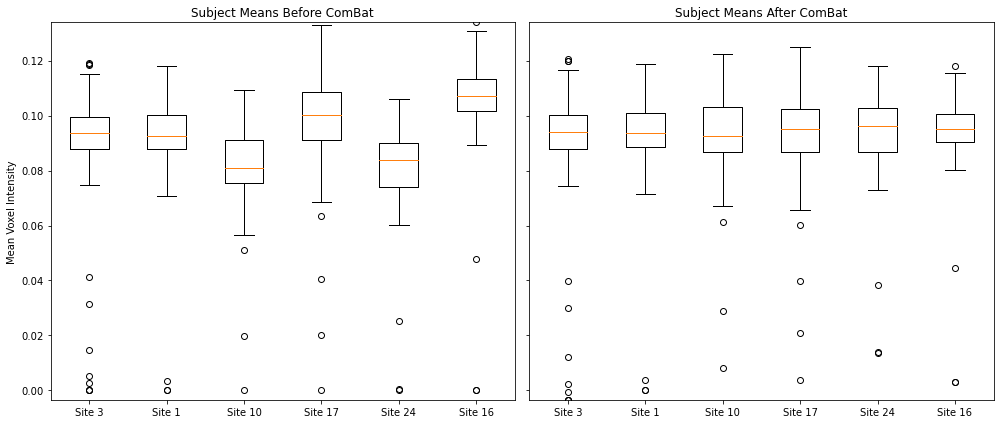

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Compute subject-wise means
subject_means_before = features.mean(axis=1)
subject_means_after = features_combat.mean(axis=1)
sites = np.array(meta_sub["siteXacq"])

# Pick top N most common sites for comparison
site_counts = meta_sub["siteXacq"].value_counts()
top_sites = site_counts.index[:6]  # Change to 8 or 10 if you want more

# Group subject means by site
means_by_site_before = [subject_means_before[sites == s] for s in top_sites]
means_by_site_after = [subject_means_after[sites == s] for s in top_sites]

# Shared y-axis range
ymin = min(subject_means_before.min(), subject_means_after.min())
ymax = max(subject_means_before.max(), subject_means_after.max())

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

axes[0].boxplot(means_by_site_before, labels=[f"Site {s}" for s in top_sites])
axes[0].set_title("Subject Means Before ComBat")
axes[0].set_ylabel("Mean Voxel Intensity")
axes[0].set_ylim(ymin, ymax)

axes[1].boxplot(means_by_site_after, labels=[f"Site {s}" for s in top_sites])
axes[1].set_title("Subject Means After ComBat")
axes[1].set_ylim(ymin, ymax)

plt.tight_layout()
plt.show()

In [16]:
def summarize_data(name, X):
    print(f"\n Summary of {name}:")
    print(f"  Global min: {np.min(X):.4f}")
    print(f"  Global max: {np.max(X):.4f}")
    print(f"  Mean across all subjects: {np.mean(X):.4f}")
    print(f"  Std across all subjects: {np.std(X):.4f}")
    

summarize_data("Before ComBat", features)
summarize_data("After ComBat", features_combat)


 Summary of Before ComBat:
  Global min: 0.0000
  Global max: 7.7176
  Mean across all subjects: 0.0939
  Std across all subjects: 0.2374

 Summary of After ComBat:
  Global min: -0.4968
  Global max: 4.6190
  Mean across all subjects: 0.0934
  Std across all subjects: 0.2354


import matplotlib.pyplot as plt

subj_means_before = features.mean(axis=1)
subj_means_after = features_combat.mean(axis=1)

subj_stds_before = features.std(axis=1)
subj_stds_after = features_combat.std(axis=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].boxplot([subj_means_before, subj_means_after], labels=["Before", "After"])
axes[0].set_title("Subject Mean Distributions")

axes[1].boxplot([subj_stds_before, subj_stds_after], labels=["Before", "After"])
axes[1].set_title("Subject Std Distributions")

plt.tight_layout()
plt.show()

## check the shape and number of voxels

In [16]:
print(features_combat.shape)

(2095, 2122945)


In [17]:
import nibabel as nib
import numpy as np

# Load one sample VBM volume (any subject, pre- or post-harmonization is fine)
example_vbm = nib.load("/home/kexinguo/Combat545/data/cat12vbm_space-MNI152_desc-gm_TPM.nii.gz")
vbm_shape = example_vbm.shape
print("3D shape of VBM image:", vbm_shape)

3D shape of VBM image: (121, 145, 121)


In [18]:
expected_voxels = np.prod(vbm_shape)
print("Expected flattened size:", expected_voxels)

Expected flattened size: 2122945


In [19]:
features_3d = features_combat.reshape(-1, 121, 145, 121)
print("Reshaped shape:", features_3d.shape)
np.save("features_3d_combat_vbm.npy", features_3d)

Reshaped shape: (2095, 121, 145, 121)


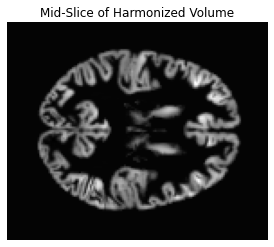

In [22]:
import matplotlib.pyplot as plt

sample = features_3d[1]  # shape: (121, 145, 121)
mid_slice = sample[:, :, sample.shape[2] // 2]

plt.imshow(mid_slice, cmap='gray')
plt.title("Mid-Slice of Harmonized Volume")
plt.axis("off")
plt.show()

# val

In [ ]:
# ---------------- VALIDATION SET ----------------
val_data_dir = "/home/kexinguo/Combat545/data/val/val_vbm"
val_label_path = "/home/kexinguo/Combat545/data/val/official_site_class_labels.tsv"
val_memmap_path = "features_val_vbm_memmap.dat"
val_subject_id_path = "subject_ids_val_vbm.npy"

val_meta = pd.read_csv(val_label_path, sep="\t")
val_meta['participant_id'] = val_meta['participant_id'].astype(str)

val_npy_files = sorted([f for f in os.listdir(val_data_dir) if f.endswith(".npy")])
val_n_subjects = len(val_npy_files)
val_sample_shape = np.load(os.path.join(val_data_dir, val_npy_files[0])).shape
val_n_voxels = np.prod(val_sample_shape)

val_features = np.memmap(val_memmap_path, dtype='float32', mode='w+', shape=(val_n_subjects, val_n_voxels))
val_subject_ids = []

for i, fname in enumerate(val_npy_files):
    subj_id = fname.split("_")[0].split("-")[1]
    val_subject_ids.append(subj_id)
    arr = np.load(os.path.join(val_data_dir, fname)).astype(np.float32)
    val_features[i] = arr.flatten()

val_features.flush()
np.save(val_subject_id_path, val_subject_ids)

val_meta_sub = val_meta.set_index("participant_id").loc[val_subject_ids]

site_counts = val_meta_sub["siteXacq"].value_counts()
singleton_sites = site_counts[site_counts <= 1].index.tolist()

val_meta_sub["SITE_COMBAT"] = val_meta_sub["siteXacq"].apply(
    lambda x: 999 if x in singleton_sites else x
)
val_covars = pd.DataFrame({"SITE": val_meta_sub["SITE_COMBAT"].values}, index=val_meta_sub.index)

#val_covars = pd.DataFrame({"SITE": val_meta_sub["siteXacq"].values}, index=val_meta_sub.index)

val_stds = np.std(val_features, axis=0)
val_mask = val_stds > threshold  # Use same threshold as training
val_features_filtered = val_features[:, val_mask]

val_features_filtered_combat = combat_by_block(val_features_filtered, val_covars, block_size=30000)

val_features_combat = np.zeros_like(val_features)
val_features_combat[:, val_mask] = val_features_filtered_combat

np.save("features_val_combat_vbm.npy", val_features_combat)

In [ ]:
# Reshape back to 3D and save
val_features_3d = val_features_combat.reshape(-1, *val_sample_shape)  # shape: (val_n_subjects, 121, 145, 121)
print("Reshaped shape:", val_features_3d.shape)
np.save("features_3d_val_combat_vbm.npy", val_features_3d)

import gzip

# Save compressed version of features_filtered_combat
with gzip.GzipFile("features_filtered_combat.npy.gz", "w") as f:
    np.save(f, features_filtered_combat)

# Save compressed version of features_combat
with gzip.GzipFile("features_combat.npy.gz", "w") as f:
    np.save(f, features_combat)

# Save compressed version of subject_ids
with gzip.GzipFile("subject_ids.npy.gz", "w") as f:
    np.save(f, np.array(subject_ids))

np.savez_compressed(
    "features_combat.npz",
    features_combat=features_combat)
!zip -9 features_combat.zip features_combat.npz